In [1]:
!pip install node2vec

  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5980 sha256=1bfb1cc012e54e1ac791e2cff6ace6b6615863884044a669d80c49a85398fbf8
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


In [3]:
import networkx as nx
from node2vec import Node2Vec

EMBEDDING_FILENAME="em_filename.txt"
EMBEDDING_MODEL_FILENAME="em_model"
EDGES_EMBEDDING_FILENAME="edg_em_file"
# asd
# Create a graph 
# graph = nx.fast_gnp_random_graph(n=10, p=0.5)
as_relation_file=open("as-rank.caida.peercones-with-IX-short.txt",'r')

graph = nx.Graph()
for line in as_relation_file:
     if line.startswith('#'):
         continue
     w = line.split('|')
     
     #graph.add_node(w[0], w[1])
     graph.add_edge(w[0], w[1])

# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=4)  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

# Look for most similar nodes
model.wv.most_similar('2')  # Output node names are always strings

# Save embeddings for later use
model.wv.save_word2vec_format(EMBEDDING_FILENAME)

# Save model for later use
model.save(EMBEDDING_MODEL_FILENAME)

# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder

edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

# Look for embeddings on the fly - here we pass normal tuples
#edges_embs[('1', '2')]
''' OUTPUT
array([ 5.75068220e-03, -1.10937878e-02,  3.76693785e-01,  2.69105062e-02,
       ... ... ....
       ..................................................................],
      dtype=float32)
'''

# Get all edges in a separate KeyedVectors instance - use with caution could be huge for big networks
edges_kv = edges_embs.as_keyed_vectors()

# Look for most similar edges - this time tuples must be sorted and as str
#edges_kv.most_similar(str(('1', '2')))

# Save embeddings for later use
edges_kv.save_word2vec_format(EDGES_EMBEDDING_FILENAME)

Computing transition probabilities:   0%|          | 0/111 [00:00<?, ?it/s]

Generating edge features: 100%|██████████| 6216/6216.0 [00:00<00:00, 163195.54it/s]


# Nowa sekcja

# Nowa sekcja

In [4]:
import sys
print(sys.version)

3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]


In [5]:
!cat em_filename.txt

111 64
57 -0.16195235 0.040875584 -0.33463117 -0.341891 -0.17099227 -0.26980412 -0.21987322 0.11488198 0.5089593 -0.17634638 0.10276835 0.13499911 -0.15198973 -0.042319056 -0.28504628 0.13323654 0.293319 -0.37591314 0.055954892 -0.68039286 0.48614427 -0.138506 -0.14101283 0.22498849 0.07244416 0.034088567 0.28449494 0.40797138 -0.84403694 0.60164285 -0.14259048 0.45308027 0.3957476 0.109108835 -0.13194212 0.38723537 -0.118230805 -0.018889775 0.14631197 -0.29508522 -0.20069583 -0.3740348 0.37619168 -0.4986165 -0.1632536 -0.037800834 0.22037904 -0.25785413 -0.31772748 -0.297099 0.5632486 -0.27771923 0.5294113 -0.22062173 -0.33879068 -0.5474602 -0.09275383 -0.27344438 -0.32938886 -0.4942743 -0.4248734 0.39620173 0.08273869 0.46093637
81 0.18481846 0.22451204 -0.1345152 0.33118686 -0.061716314 0.13125008 -0.45884648 -0.30235192 0.67557555 0.004259216 -0.25419173 0.42636088 0.6130488 0.10971056 -0.2155764 0.054184593 0.46093416 0.26780662 0.24418055 -0.3665853 0.053756837 -0.07054462 0.5064

Algorytm t-SNE

*   algorytm nalezący do klasy manifold learning 
*   algorytm oblicza nową reprezentację danych uczących, ale nie zezwala na przekształcenie nowych danych (nie można zastosować do zbioru uczącego)
*   Ideą jest znalezienie dwuwymiarowej reprezentacji danych, która najlepiej zachowuje odległości pomiędzy punktami 
*   Rozpoczyna się od losowej dwuwymiarowej reprezentacji dla każdego punktu danych, a następnie próbuje zbliżyć punkty, które są blisko pierwotnej przestrzenii cech, a punkty położone daleko od siebie w pierwotnej przestrzenii cech są daleko od siebie




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ConversionWarning: Some errors were detected !
    Line #1 (got 2 columns instead of 64)
  


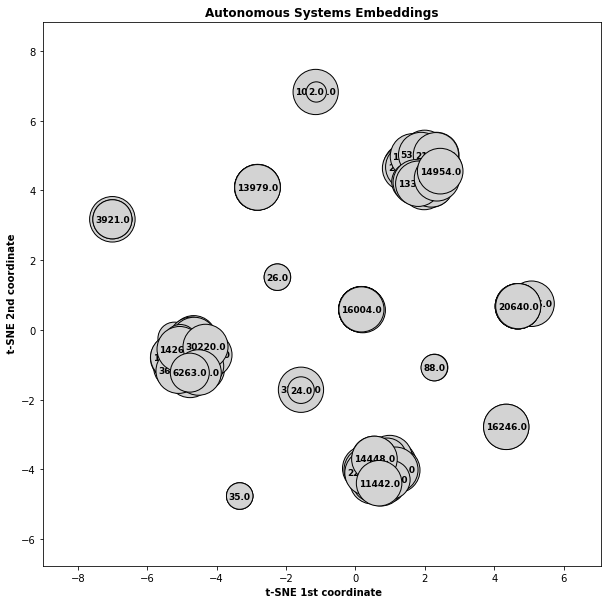

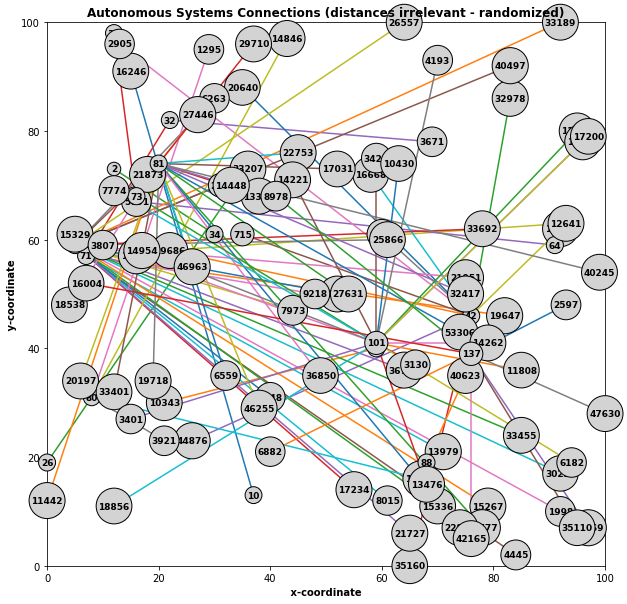

In [6]:
#@title t-SNE
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random 

# extracting data without id's
File_data = np.genfromtxt("em_filename.txt", dtype=float,invalid_raise = False,usecols=np.arange(1, 65))

# extracting id's from source file
as_labels = np.genfromtxt("em_filename.txt", dtype=float,invalid_raise = False,usecols=np.arange(0, 1))

# making embeddings 
embedding = TSNE(n_components=2,learning_rate='auto',init='random').fit_transform(File_data)

# plot limiting
plt.figure(figsize=(10,10))
plt.xlim(embedding[:,0].min()-2,embedding[:,0].max() + 2)
plt.ylim(embedding[:,1].min()-2,embedding[:,1].max() + 2)

# assigning numbers to points in plot 
for i in range(len(embedding)):
  plt.text(embedding[i,0],embedding[i,1],str(as_labels[i]),fontdict={'weight': 'bold', 'size': 9},ha="center", va="center",bbox = dict(boxstyle=f"circle,pad={0.25}", fc="lightgrey"))

# plotting
plt.xlabel(' t-SNE 1st coordinate',fontweight="bold")
plt.ylabel(' t-SNE 2nd coordinate', fontweight="bold")
plt.title('Autonomous Systems Embeddings',fontweight="bold")
plt.show()

# Connections plotting
plt.figure(figsize=(10,10))
plt.xlim(0,100)
plt.ylim(0,100)

node_list = {}

# randomizing AS locations in map
for i in graph.nodes:
  x_random = random.randint(0,100)
  y_random = random.randint(0,100)
  node_list[i]= ([x_random,y_random])  
  plt.text(x_random,y_random,str(i),fontdict={'weight': 'bold', 'size': 9},ha="center", va="center",bbox = dict(boxstyle=f"circle,pad={0.25}", fc="lightgrey"))

# Looking for edges
for j in graph.edges:
  plt.plot([node_list[j[0]][0],node_list[j[1]][0]],[node_list[j[0]][1],node_list[j[1]][1]])

plt.title('Autonomous Systems Connections (distances irrelevant - randomized)',fontweight="bold")

print()
print()

plt.xlabel(' x-coordinate ',fontweight="bold")
plt.ylabel(' y-coordinate ', fontweight="bold")
plt.show()